# AirBnB - A Sentiment Analysis

# Introduction

## [What is Airbnb and how does it work?](https://www.airbnb.com/help/article/2503/what-is-airbnb-and-how-does-it-work)
#### A community built on sharing
_"Airbnb began in 2008 when two designers who had space to share hosted three travelers looking for a place to stay. Now, millions of hosts and travelers choose to create a free Airbnb account so they can list their space and book unique accommodations anywhere in the world. And Airbnb experience hosts share their passions and interests with both travelers and locals."_

#### Trusted services
_"Airbnb helps make sharing easy, enjoyable, and safe. We verify personal profiles and listings, maintain a smart messaging system so hosts and guests can communicate with certainty, and manage a trusted platform to collect and transfer payments._"


In [171]:
from IPython.core.display import display, HTML, Markdown, Javascript
if False:
    HTML('''<script>
    code_show=true; 
    function code_toggle() {
     if (code_show){
     $('div.input').hide();
     } else {
     $('div.input').show();
     }
     code_show = !code_show
    } 
    $( document ).ready(code_toggle);
    </script>
    <form action="javascript:code_toggle()" id="topdiv"><input type="submit" value="Click here: Toggle on/off code."></form>''')



In [166]:
from IPython.core.display import display, HTML, Markdown, Javascript

# paths
## 1. Code
myCodePath = "helper_files"
## 2. Data
myDataPath = "data"
import sys
sys.path.append(myCodePath)

from formattingWidth import formatting_width, hideCode, myHTML, myHTMLreplace
from pandasExt import *

formatting_width()
# hideCode()


In [84]:
import os
import glob
import numpy as np
import pandas as pd
# turn off scientific notation in pandas
pd.set_option('display.float_format', lambda x: '%.2f' % x)
# show full column text
pd.set_option('display.max_colwidth', None)
# extend output
pd.set_option('display.max_rows', 100000)

from time import time
               
import matplotlib.pyplot as plt
import seaborn as sns
import seaborn as sb
from pprint import pprint
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import fasttext

%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

# Calculate Sentimants?
## The lists of sentiments are saved as pickle files
## To redo this analysis, set these to True
sentiments=False
sentiments_eng=False

In [85]:
import calendar as cal
# calendar variable orders
day_order = [day for day in cal.day_name]
month_order = [mon for mon in cal.month_name][1:]

In [86]:
# location of all data files
all_files = glob.glob(os.path.join(myDataPath , "*.csv") )

# load all datafiles as dataframes, save as a dictionary
dfs = {f.split("/")[-1].replace(".csv",""): pd.read_csv(f, low_memory=False) for f in all_files if "csv" in f}

In [87]:
# add city key to each dataframe
for key in dfs.keys():
    if "boston" in key:
        dfs[key]['city'] = "Boston"
    else:
        dfs[key]['city'] = "Seattle"

In [88]:
# concatenate the relevant datafiles
calendar = pd.concat([dfs[key] for key in dfs.keys() if 'calendar' in key]).reset_index(drop=True)        
listings = pd.concat([dfs[key] for key in dfs.keys() if 'listings' in key]).reset_index(drop=True)          
reviews = pd.concat([dfs[key] for key in dfs.keys() if 'reviews' in key]).reset_index(drop=True) 

In [128]:
# If dataframes are to be merged:
## currently, no
if False:
    # merge listing with calendar
    df = listings.merge(calendar, left_on='id', right_on='listing_id')
    # merge result with reviews
    df = df.merge(reviews, left_on='id', right_on='listing_id')

In [129]:
# Function: create date variables
def dateVariables(df,dateVar):
    df[dateVar] = pd.to_datetime(df[dateVar])
    df['year'] = df[dateVar].dt.year
    df['month'] = df[dateVar].dt.strftime("%B")
    df['month'] = pd.Categorical(df['month'],
                                      categories = month_order,
                                      ordered=True)
    df['day'] = df[dateVar].dt.strftime("%A")
    df['day'] = pd.Categorical(df['day'],
                                      categories = day_order,
                                      ordered=True)

# create date variables
dateVariables(calendar,'date')
dateVariables(reviews,'date')
dateVariables(listings,'last_scraped')


# reencode available to booleen
calendar['available'] = calendar['available'].replace({"t":True,"f":False})
# reencode price to float
calendar["price"] = calendar.price.str.replace("$","").str.replace(",","").astype(float)

In [130]:
# extract the dataframes for the latest dates
recent_calendar = calendar.loc[calendar.groupby('listing_id').date.idxmax()].reset_index(drop=True)
recent_reviews = reviews.loc[reviews.groupby('listing_id').date.idxmax()].reset_index(drop=True)


## What Information Do We Have?
The source of the data is [kaggle.com](kaggle.com). The data used in this analysis is for two cities: [Boston](https://www.kaggle.com/airbnb/boston) and  [Seattle](https://www.kaggle.com/airbnb/seattle/data)

The data files are for _calendar_, _reviews_ and _listings_. The listings datafile contains one observation per listings, with information related to: Basic information (location, space, host, images (of listing and host), availability), Reviews, and Price. The calendar and reviews datafiles contain multiple entries per listing relating to individual availability data and reviews.


In [89]:
myHTML(f'''Where the data relates to  {len(listings.id.unique())} unique listings, with observations and variables:  listings {listings.shape}, calendar {calendar.shape}, reviews {reviews.shape}''')

# myHTML(f'''\nColumns in:<br>calendar: {', '.join([str(x).replace('_',' ').title() for x in calendar.columns])},
#        <br><br> listings: {', '.join([str(x).replace('_',' ').title() for x in listings.columns])},
#        <br><br> reviews: {', '.join([str(x).replace('_',' ').title() for x in reviews.columns])}''')

## Questions

For anyone new to AirBnB _(like me)_, the most obvious questions relate to:
- Locaton: If I want to avail of this service, what choices do I have in terms of location?
- Price: Compared to getting a hotel, is this service affordable?
- Reviews: What am I getting for the price that I pay? Is is a quality service?

# Location

In [169]:
listingsCount = listings.groupby('city').size()

myHTML(f'''There are {listingsCount.loc["Boston"]} unique listings in the Boston area, and {listingsCount.loc["Seattle"]} unique listings in the Seattle area''')


In [91]:

def avgBy(df,var,varname,groupby='zipcode'):
    '''
    avgBy - groupby by, get average of var, join on original dataframe
            extract one complete row of the dataframe for each group
    '''
    if isinstance(df[var][0],str):
        df[var]=df[var].str.extract(r'(\d+\.\d+)').astype(float)
    df = df.dropna(subset=[var])
    plistings = df.join(df.groupby(groupby)[var].transform('mean'),rsuffix="_d")
    plistings = plistings.rename({f"{var}_d":varname},axis=1)
    pOne = plistings.groupby(groupby).first().reset_index()
    pOne[varname] = pOne[varname].apply(lambda x: np.sqrt(x)*10).astype(int)
    return pOne


In [92]:
def countBy(df,var,varname,groupby='zipcode'):
    '''
    avgBy - groupby by, get average of var, join on original dataframe
            extract one complete row of the dataframe for each group
    '''
    if isinstance(df[var][0],str):
        df[var]= df[var].str.extract(r'(\d+\.\d+)').astype(float)
    df = df.dropna(subset=[var])
    plistings = df.join(df.groupby(groupby)[var].transform('size'),rsuffix="_d")
    plistings = plistings.rename({f"{var}_d":varname},axis=1)
    pOne = plistings.groupby(groupby).first().reset_index()
    pOne[varname] = pOne[varname].apply(lambda x: np.sqrt(x)*10).astype(int)
    return pOne


In [93]:
avgRatings = avgBy(listings,'review_scores_rating','Average Ratings',groupby='zipcode')
avgPrice = avgBy(listings,'price','Average Price',groupby='zipcode')
countZip = countBy(listings,'id','Count',groupby='zipcode')

In [94]:
def mapRegions(df, s=10, percentile=False, labels=False, annot=""):
    '''
    mapRegions - plots a map of Boston and Seattle, with observations for lat/lon
                 which depend on dataframe used
    inputs -     df - a dataframe contain lat lon information (optional information about a third variable)
                 s - size of points. Either fixed, or depending on a third variable
    '''
    # to overwrite s type check later
    switch=False
    if not isinstance(s,int):
        switch=True
    # load maps
    boston_map = plt.imread('boston_zip_map.png')
    seattle_map = plt.imread('seattle_zip_map.png')
    
    def coords(grp):
        return (grp.longitude.min(), grp.longitude.max(),      
                grp.latitude.min(),  grp.latitude.max())


    # create fig with subplots
    fig, ax = plt.subplots(1,2, figsize = (14,10))
                
    # unique cities
    cities = df.city.unique()
    # loop over cities
    for i, city in enumerate(cities):
        # Map
        mapC = plt.imread(f'{city.lower()}_map.png')
        # city dataframe
        dfC = df.loc[df.city==city]
        # Bounding box
        BBox = dfC.groupby('city').apply(coords)
        BBoxC = BBox.loc[city]
        
        # check if the size is a fixed number or variable
        if switch:
            sC = dfC[s]
            sT=s           
        else:
            sC=s
            sT="Spatial Location"

        # color points by percentile
        if percentile:
            scPer = dfC[percentile[0]].quantile(percentile[1])
            dfC['color'] = 'b'
            dfC.loc[dfC[percentile[0]]<scPer,'color'] = 'r'
            cP = dfC['color']
        else:
            scPer = False
            cP = 'b'
            

        # plot points, with size relative to the value of the s variable
        ax[i].scatter(dfC.longitude, dfC.latitude, zorder=1, alpha= 0.6, c=cP, s=sC)
        if labels:
            for ind in range(dfC.shape[0]):
                # set text color
                if scPer and dfC.iloc[ind][s] < scPer:
                    tColor='red'
                else:
                    tColor='black'
    #             print(dfB['longitude'][ind],dfB['latitude'][ind])
                # Overall averages
                ax[i].annotate(f"{annot}{dfC.iloc[ind][s]}",
                            (dfC.iloc[ind]['longitude'],dfC.iloc[ind]['latitude']),
                            size=12, ha='left',
                            va='top', weight = "normal",
                            color = tColor,
    #                             xytext=(1, 1), textcoords='axes fraction',
                            bbox=dict(facecolor = "white", edgecolor="grey", boxstyle='round,pad=0.05')
                            )

        ax[i].set_title(f'Plotting  {sT}  Data on {city} Map',y=1.02)
        ax[i].set_xlim(BBoxC[0],BBoxC[1])
        ax[i].set_ylim(BBoxC[2],BBoxC[3])
        ax[i].imshow(mapC, zorder=0, extent = BBoxC, aspect= 'auto');
    plt.tight_layout();


We can plot the locations for AirBnB listings for both Boston and Seattle. Surprisingly _(for me)_ there are listings dotted around each city.

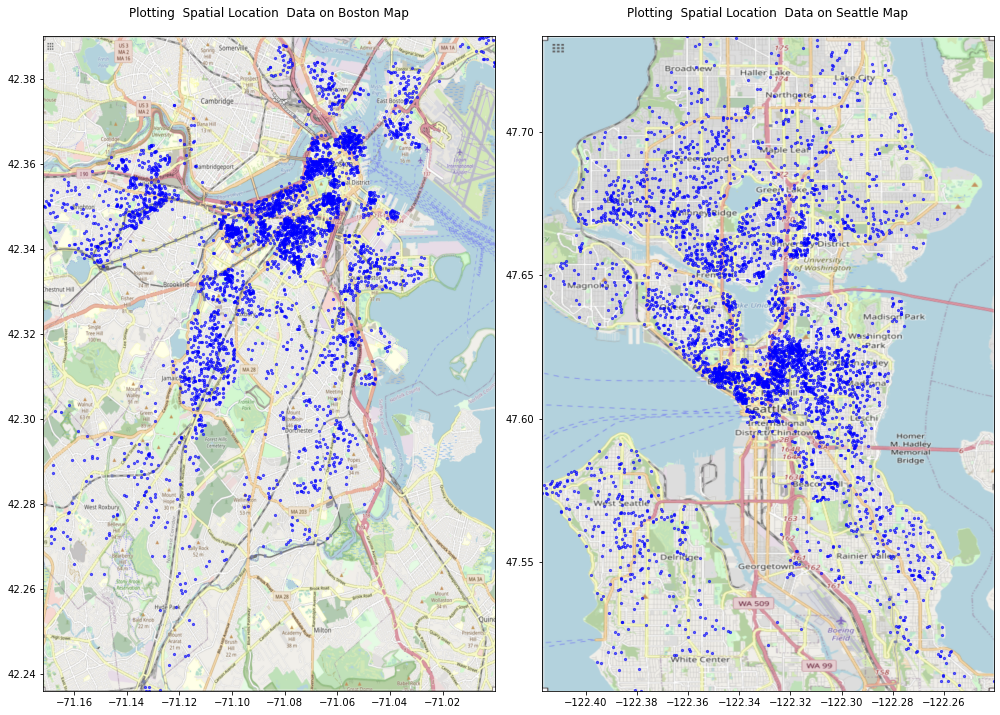

In [96]:
mapRegions(listings, s=5)

In [170]:
percAvailability = listings.groupby('city').availability_365.quantile(0.5)

myHTML(f'''The median availability, i.e. the median number of days of the year that the listing is available, is {percAvailability.loc["Boston"]} for Boston, and {percAvailability.loc["Seattle"]} for Seattle''')


percAvailability = listings.groupby('city').availability_365.quantile(0.75)

myHTML(f'''The 75th percentile of availability, i.e. the median number of days of the year that the listing is available, is {percAvailability.loc["Boston"]} for Boston, and {percAvailability.loc["Seattle"]} for Seattle''')


So, for Boston, the 50% of the listings are available for roughly half the year.Whereas for Seattle, at least 50% of the listings are available almost year round.

In [173]:
"Gloria SANCHEZ".title()

'Gloria Sanchez'

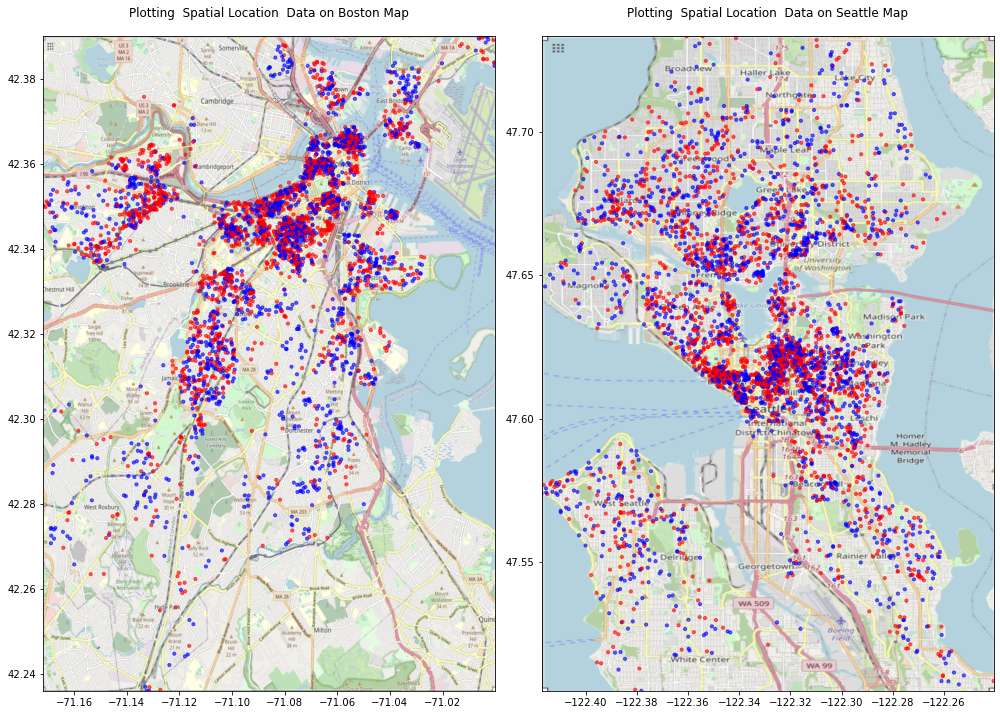

In [98]:
mapRegions(listings, percentile=('availability_365',0.5))

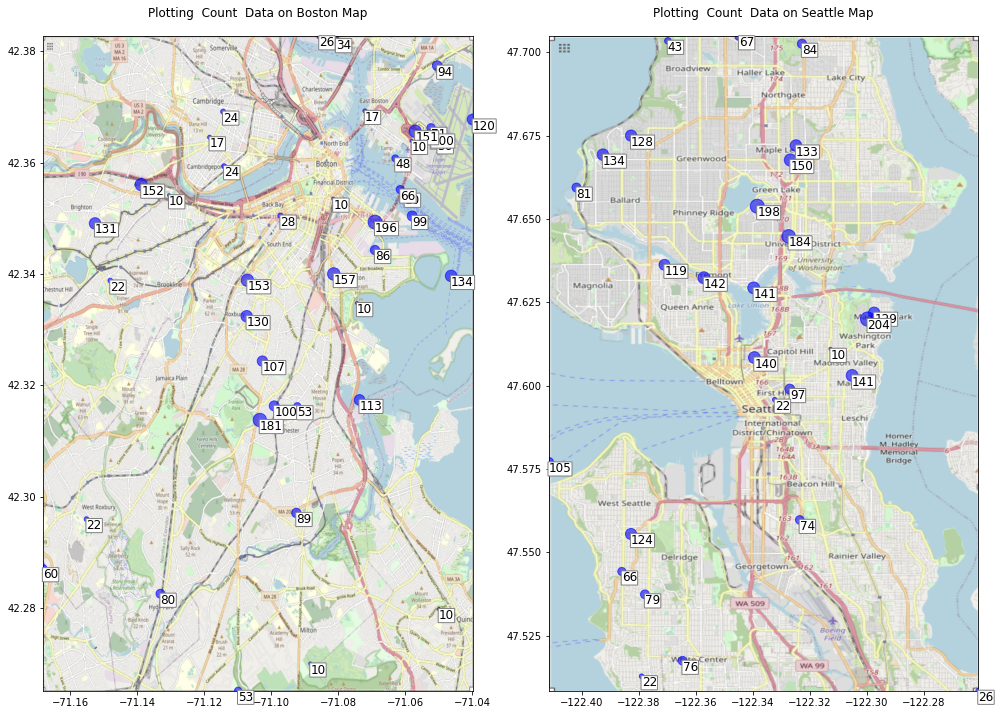

In [99]:
mapRegions(countZip,s='Count', labels=True)

# Price

In [100]:
medianPrice = listings.groupby('city').price.quantile(0.5)
minPrice = listings.groupby('city').price.quantile(0.01)
maxPrice = listings.groupby('city').price.quantile(0.99)

myHTML(f'''The median price is \${medianPrice.loc["Boston"]} for Boston, and \${medianPrice.loc["Seattle"]} for Seattle (with the 1st percentile price being: \${minPrice.loc["Boston"]}  and \${minPrice.loc["Seattle"]},
and the 99th percentile price being \${maxPrice.loc["Boston"]}  and \${round(maxPrice.loc["Seattle"],2)}, respectively)''')


The breakdown of prices per zipcode for each city is:

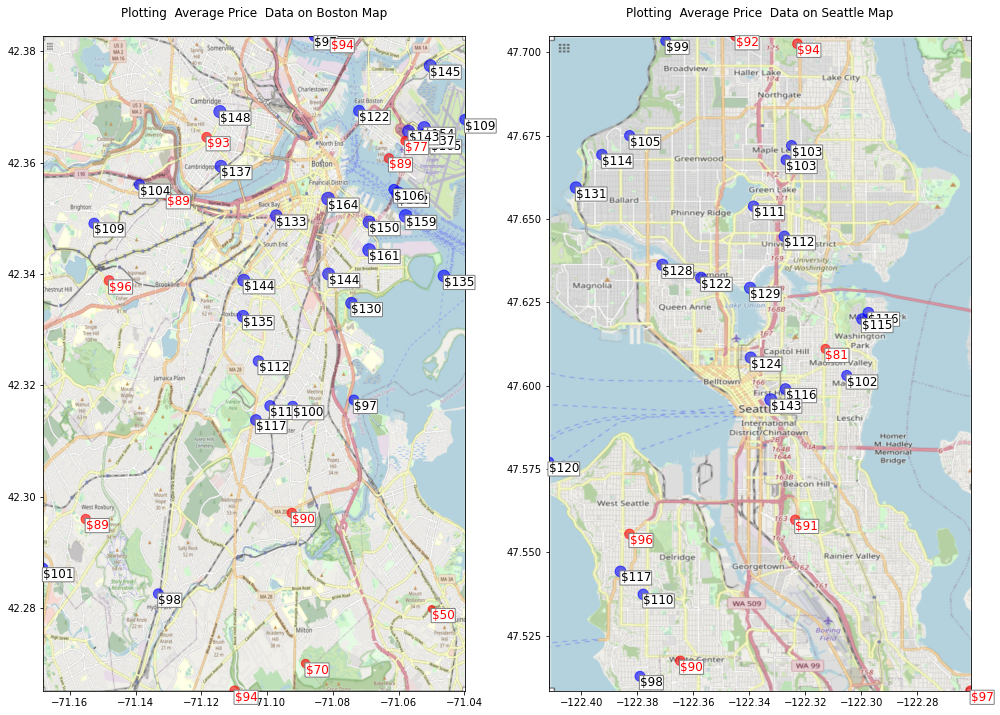

In [101]:
mapRegions(avgPrice,s='Average Price',percentile=('Average Price',0.25),labels=True, annot="$")

Where the prices in red are for zipcodes where the price is at or below the 25th percentile.

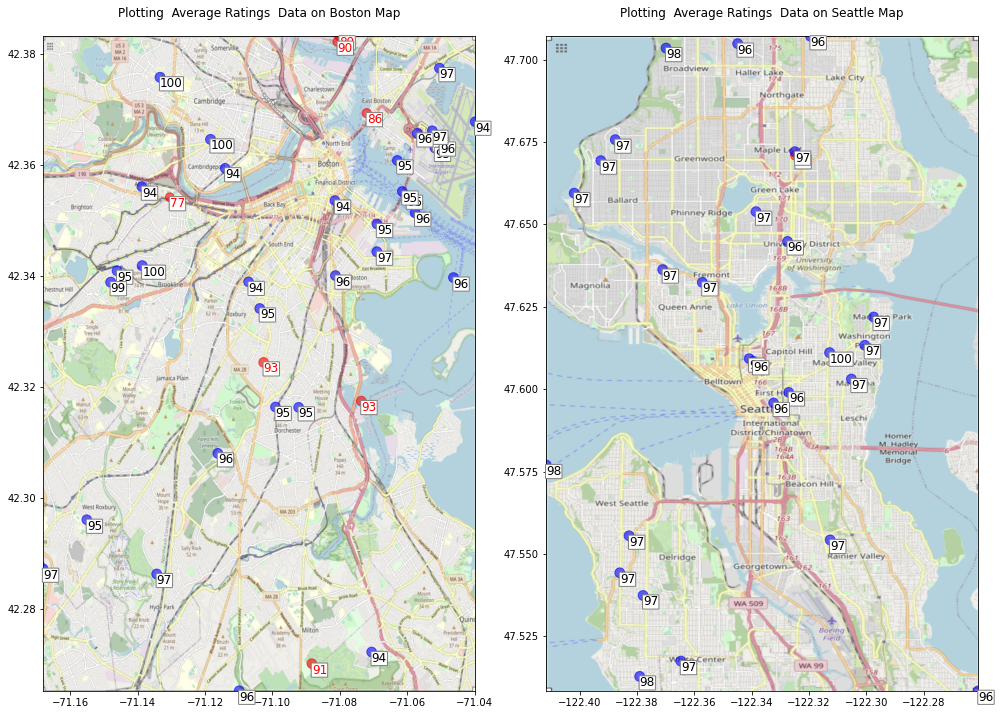

In [102]:
mapRegions(avgRatings,s='Average Ratings',percentile=('Average Ratings',0.25),labels=True, annot="")

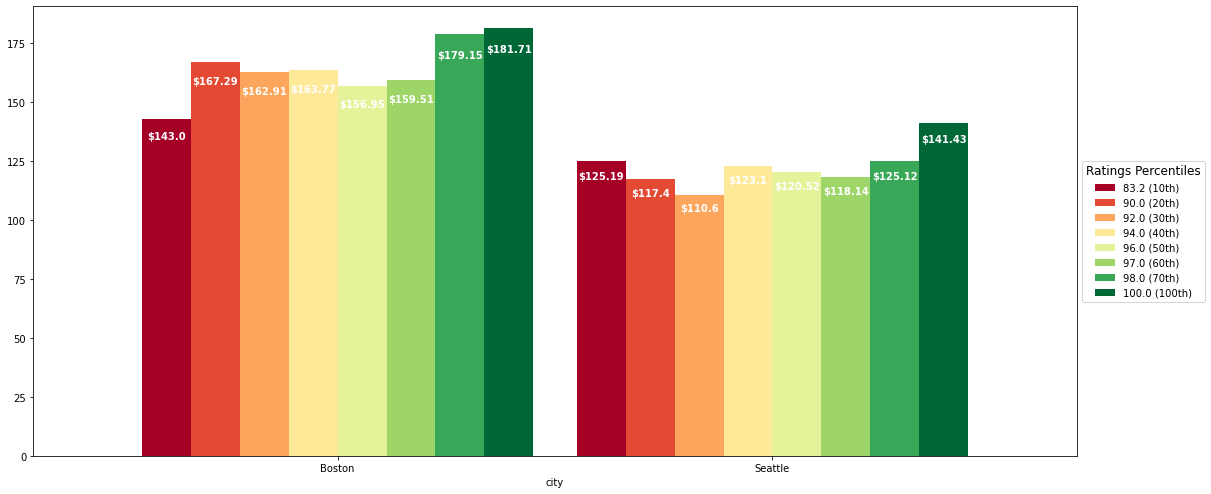

In [103]:
if isinstance(listings["price"][0],str):
    listings["price"]=listings.price.str.extract(r'(\d+\.\d+)').astype(float)

from pandasExt import *
new_name = myCut(listings,'review_scores_rating')

listings[[new_name,'review_scores_rating']]

Waiting = listings.groupby(['city',new_name])['price'].mean().unstack().plot.bar(rot=0,
                                                                      figsize=[18.70, 8.27],
                                                                      cmap="RdYlGn",
                                                                      width=0.9)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5),
           title="Ratings Percentiles", title_fontsize = 12);

for i in Waiting.patches:
#     print(i)
#     Waiting.text(i.get_x(),i.get_height()+1000,str(i.get_height().astype(int)),rotation=0,fontsize=12,weight = "bold", color='white')
    Waiting.text(i.get_xy()[0] + i.get_width()*0.5, # X position
                 i.get_xy()[1] + i.get_height()*0.95,# Y position
                 f"${str(round(i.get_height(),2))}",
                 ha="center",
                 va="center",# Text
                 rotation=0,
                 fontsize=10,
                 weight = "bold",
                 color='white');

#### Is there information in the calendar or reviews data files that would be useful?

In [104]:
calendar.sample(5)

listing_id        date available    price     city
1473187    10274175  2016-02-20         t   $46.00  Seattle
1476002     8193332  2016-11-06         t  $100.00  Seattle
1330041     3269390  2016-12-15         t   $95.00  Seattle
2112622     7713043  2016-01-06         t   $75.00  Seattle
23788      12806707  2017-07-04         t   $60.00   Boston

In [105]:
reviews.sample(5)

listing_id        id        date  reviewer_id reviewer_name  \
43699      2746782  38121292  2015-07-13     28180522         Anita   
134473     8523157  83104785  2016-07-01     75099287           Jon   
14338      1796302  10641558  2014-03-01     11918488      Meredith   
89471      3601424  32554893  2015-05-19     21341343       Crystal   
62799      7305969  53210004  2015-11-06     11489767           Amy   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           comments  \
43699   We checked in very late on Friday and since we approached from the street above the property, walking down the stairway, we had to disturb Jean-Marc to make sure we had the right place. He was very gracious and welcoming.\r\n\r\nThis unit was very clean, and just as pictured. The location is quiet and private, and since we came back rather late at night, we were happy not to disturb anyone. The bed was very comfortable and was appreciated after our busy days in Seattle. Great coffee with the Keurig, and the refrigerator and microwave would have been used, but we were hardly there!   
134473                                                                                                                                                                                                                                                             The hosts were great. They  provided outstanding communication before and during the trip. They offered suggestions about where to go and where to eat. The accommodations provided were immaculate and spacious. WARNING: you will fall in love with the cat and dogs. I returned two additional times due to the pets and hospitality. Thanks!   
14338                                                                                            Susanna was a fantastic hostess during my recent stay. She was accessible and accommodating, and I felt welcome from the moment we first communicated. Her home is lovely, her pets are sweet, and her local knowledge is impressive. She provided expert guidance on everything from restaurants to city-wide transit, and she made sure my friend and I had everything we needed at all times. I'll certainly plan my next trip to Seattle around Susanna's availability. I can't imagine staying anywhere else!   
89471                                                                                                                                                                                                                                                                                                                         Erin was an extremely gracious host.  The room was spacious and had plenty of storage for all of our luggage and clothing.  We weren't at the home much, but we're thankful that we could come in after a long day and get straight to rest!  Room was comfy and the house was clean!   
62799                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   Emily was a great hostess and made me feel right at home with anything I needed and great recommen

In [106]:
import os
import pickle
class SentimentsWordCloud(object):
    '''extractEnglish() = extract only english entries
       extractStrings() = transform the column of string to a single string - calls extractEnglish is required
       extractSentiments() = extracts words with positive, neutral or negative sentiments
       wordCloudViz() = create a word cloud visualization from sentiments (positive and negative only)
    '''
    def __init__(self,df,dfCol,groupby=False,english=False,englishPercent=50,stopwords = [],update=False,proportional=False):
        '''
        Required inputs: df= relevant dataframe
                         reviewCol = A column (of strings) of a dataframe
        Optional inputs: groupby = a category to groupby
                         english = whether or not to extract english strings only
                         englishPercent = if english strings, probability of match
                         stopwords = a list of word to omit from the word cloud
        '''
        self.df = df
        self.dfCol = dfCol
        self.groupby = groupby
        self.english = english
        self.englishPercent = englishPercent
        self.stopwords = stopwords
        self.pickleFile = False
        self.update = update
        self.proportional=proportional
        # get current working directory file list
        self.file_list = os.listdir(os.getcwd())
        # if the file (using the standard naming convention) is in cwd
        # load it, and use it instead of recreating the sentitments dictionaries
        # unless update is specified
        if f"sentiments_{self.groupby}_{self.english}.pickle" in self.file_list and not self.update:
            self.pickleFile = True
            with open(f"sentiments_{self.groupby}_{self.english}.pickle", 'rb') as handle:
                self.sentiments = pickle.load(handle)
        else:
            # only load the fasttext model if no pickle file is available
            # AND english only text is required.
            if self.english:
                # initialize fasttext model
                self.ft = fasttext.load_model('lid.176.bin')

        
    def extractEnglish(self,text):
        '''
        Use fasttext to extract only english strings
            with percentage accuracy self.englishPercent
            - creates a boolean for each row
        '''
        # check for NaN
        if not isinstance(text,str):
            return False
        """Return a boolean if text is predicted (over perc% to be english)"""
        result = self.ft.predict(text.replace("\n"," ").lower(),k=1)
        if result[1][0] > self.englishPercent/100 and result[0][0] == '__label__en':
            return True
        else:
            return False
        
    def extractEnglishStrings(self):
        '''
         # if English only statements are required, filter the dataframe
        '''
        # if the file (using the standard naming convention) is in cwd
        # load it, and use it instead of recreating the sentitments dictionaries
        # unless update is specified
        if "sentiments_is_English_rows.pickle" in self.file_list and not self.update:
            with open("sentiments_is_English_rows.pickle", 'rb') as handle:
                is_eng = pickle.load(handle)
        else:
            # apply extractEnglish to each row
            is_eng = self.df[self.dfCol].apply(self.extractEnglish)
        # filter the dataframe
        self.df = self.df.loc[is_eng]
        # this part takes a while, so I am going to pickle the boolean series
        # of whether a row is predicted to be in english
        with open(f"sentiments_is_English_rows.pickle", 'wb') as handle:
            pickle.dump(is_eng, handle, protocol=pickle.HIGHEST_PROTOCOL)
        return is_eng
        
    def extractStrings(self):
        '''
        extract string(s) from the dataframe column
        One string if not grouping
        One string per group if grouping
        '''
        # if English only statements are required, filter the dataframe
        if self.english:
            self.extractEnglishStrings()
        if self.groupby:
            self.commentsString = self.df.dropna(subset=[self.dfCol]).groupby(self.groupby)[self.dfCol].apply(" ".join)
        else:
            self.commentsString = pd.Series(" ".join(self.df.dropna(subset=[self.dfCol])[self.dfCol]))
            self.commentsString.index = ["All"]
        return self.commentsString
            
    def extractSentiments(self):
        if self.pickleFile:
            return self.sentiments
        # extract the strings required
        self.extractStrings()
        # import required modules
        from nltk.sentiment.vader import SentimentIntensityAnalyzer
        
        # create a dictionary to capture the sentiments for each group
        self.sentiments ={}
                                 
        for indx in range(self.commentsString.shape[0]):
            commentString = self.commentsString.iloc[indx]
            # create a list from the string
            words_list=commentString.split()

            # create an instance of the analyzer
            sid = SentimentIntensityAnalyzer()
            # lists to store the sentiments
            pos_word_list=[]
            neu_word_list=[]
            neg_word_list=[]

            # dictionary container for the lists
            sentiments = {}

            # loop through the lists of words
            for word in words_list:
                if (sid.polarity_scores(word)['compound']) >= 0.5:
                    pos_word_list.append(word)
                elif (sid.polarity_scores(word)['compound']) <= -0.5:
                    neg_word_list.append(word)
                else:
                    neu_word_list.append(word)                

            sentiments['Positive'] = pos_word_list        
            sentiments['Neutral'] = neu_word_list    
            sentiments['Negative'] = neg_word_list
            
            self.sentiments[self.commentsString.index[indx]] = sentiments
            
        # this part takes a while, so I am going to pickle the results of each run
        # then use those files to avoid having to run 
        pickle_filename = f"sentiments_{self.groupby}_{self.english}.pickle"
        with open(pickle_filename, 'wb') as handle:
            pickle.dump(self.sentiments, handle, protocol=pickle.HIGHEST_PROTOCOL)
        
        return self.sentiments
    
    
    def wordCloudViz(self):
        # generate sentiments
        sentiments_dict = self.extractSentiments()
        for item in self.stopwords:
            STOPWORDS.add(item)
        
        for key in sentiments_dict:
            sentiments_all = sentiments_dict[key]
            # ensure that there are words for the word cloud
            # if not, move on to the next key
            if 0 in [len(sentiments_all[k]) for k in sentiments_all.keys()]:
                continue
            
            # If the area of plots is set to be proportional (using a layout N x N, with plots (N-1)*(N-1) and 1*1
            # for example if the ratio is 100:1, N**2 -2N -99
            # then an adjustment to the width of the wordCloud has to be made (i.e. the number of columns the plot
            # occupies)
            c = int(len(sentiments_all["Positive"])/len(sentiments_all["Negative"])) -1
            import math
            # number of columns that generates proportional subplots
            ncols = int(2+math.sqrt((1**2) - (4*(-2*c)))/(2*1))
            if self.proportional:
                wcWidth = int(1050*((ncols-1)/ncols))
            else:
                wcWidth=1050

            wordCloud = {}
            for label, value in {'Positive':['salmon','Pastel1'],"Negative":['grey',"Dark2"]}.items():
                wordCloud[label] = WordCloud(width = 1600, height = wcWidth,
                                      random_state=1,
                                      background_color=value[0], colormap=value[1],
                                      collocations=False, stopwords = STOPWORDS).generate(" ".join(sentiments_all[label]))
            if not self.proportional:
                # Set figure size
                fig, ax = plt.subplots(1,2, figsize=(14.69, 8.27))
                for ind, label in enumerate(wordCloud):
                    # Display image
                    ax[ind].imshow(wordCloud[label]) 
                    # No axis details
                    ax[ind].axis("off");
                    ax[ind].set_title(f"{label} sentiments for {key} reviews".title(), fontsize=14, weight="bold")
                plt.tight_layout()
                plt.show()
            else:
                # set area of plots to be proportional (using a layout N x N, with plots (N-1)*(N-1) and 1*1
                # for example if the ratio is 100:1, N**2 -2N -99
                c = int(len(sentiments_all["Positive"])/len(sentiments_all["Negative"])) -1
                
                import math
                ncols = int(2+math.sqrt((1**2) - (4*(-2*c)))/(2*1))
                nrows=ncols
                fig, axs = plt.subplots(ncols=ncols, nrows=nrows, figsize=[14.7,8.27])
                # get gridspec, upper left plot
                gs = axs[0, 0].get_gridspec()
                # remove all axis
                for ax in axs.flatten():
                    ax.axis("off")
                # remove the underlying axes
                for ax in axs[0:ncols-1].flatten():
                    ax.remove()
                # larger plot
                axbig = fig.add_subplot(gs[0:, 0:ncols-1])
                # smaller plot
                axsmall=axs[nrows-1][ncols-1]
                axbig.axis("off")
                fig.tight_layout()
                for ind, label in enumerate(wordCloud):
                    if label == "Positive":
                        axbig.imshow(wordCloud[label]) 
                    else:
                        axsmall.imshow(wordCloud[label]) 
                fig.suptitle(f"Sentiments for {key} reviews\n(ratio of {c+1}:1)".title(), fontsize=14, weight="bold", y=1.05)
                fig.show()
            yield
    
  

# Reviews

In [107]:
myHTML(f"To create all of the required pickle files took {round(1835.3076219558716,2)} seconds, or {round(1835.3076219558716/60,2)} minutes")

We have seen that the reviews are mostly positive. We are going analyze the reviews to see the sentiments expressed in the review. We are going use natural language process to scan each of the reviews for key _"sentiments"_ that are expressed in the reviews.

We will do this in three ways. 
- Firstly, we will naively just scan the reviews for sentiments.
- Once that is complete, we will review the results to see if they are consistent with the review ratings. We will use that information to update our analysis.
- Finally, we will will perform a review of our update and present our final analysis.

In [108]:
recreate_pickle_files = False
if recreate_pickle_files:
    # start timer
    t0=time()
    options = [False, 'city', 'listing_id']
    for option in options:
        for value in [True, False]:
            swc = SentimentsWordCloud(reviews,'comments',groupby=option,english=value,update=True)
            swc.extractSentiments()
    print(f'Time Taken: {time()-t0}')

## Naive Examination

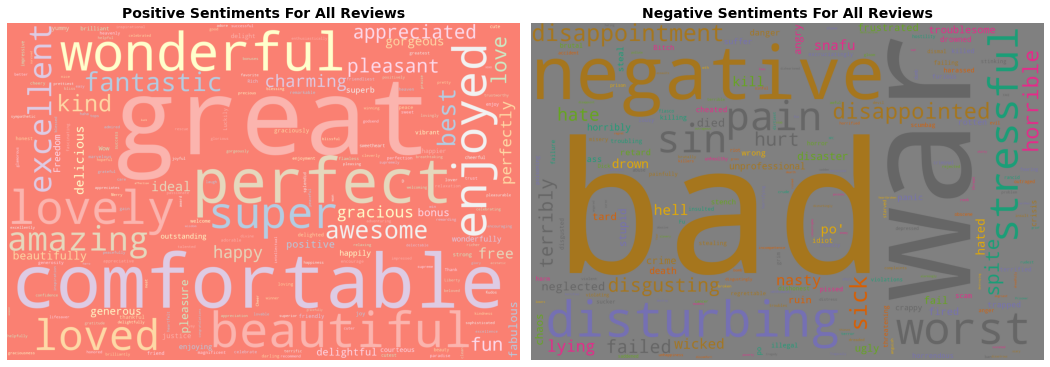

In [109]:
swc = SentimentsWordCloud(reviews,'comments')
vizGen = swc.wordCloudViz()
next(vizGen)

The results for the positive reviews are not too surprising, the results for the negative sentiments are shocking. 

Let's scan through some of the reviews to see where the words `die`, `rob`, `killer` and `war` appear. It turns out, we only need to look at the one example of each to see why those apparently shocking terms are used.

In [110]:
def highlightKeywords(df,var,word):
    line = df[var].dropna().loc[df[var].dropna().str.lower().str.contains(word.lower())].iloc[0]
    myHTMLreplace(line, word=word)

#### Die

In [111]:
highlightKeywords(reviews,'comments',' Die')

#### Killer

In [112]:
highlightKeywords(reviews,'comments',' Killer ')

#### Rob

In [113]:
highlightKeywords(reviews,'comments',' Rob')

So some of the reviews are not in english, and some of the _"sentiments"_ detected are due to colloquial usages. First, let's remove the non-english reviews.

## English Only Reviews

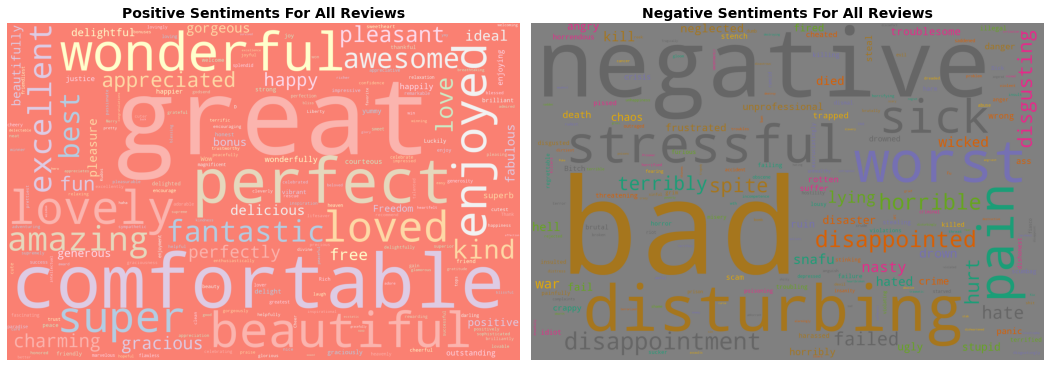

In [114]:
swc = SentimentsWordCloud(reviews,'comments',english=True)
vizGen = swc.wordCloudViz()
next(vizGen)

Surprisingly, _"die"_ remains, but _"kller"_ (which is mainly english colloquial) doesn't. Unsurprisingly, _"rob"_ still remains. Let's see why _"die"_ is used.

In [115]:
file_list = os.listdir(os.getcwd())
if "sentiments_is_English_rows.pickle" in file_list:
    with open("sentiments_is_English_rows.pickle", 'rb') as handle:
        is_eng = pickle.load(handle)

eng_comments = reviews.loc[is_eng]
highlightKeywords(eng_comments,'comments',' die ')

Ok, more colloquial usage, what about _"killer"_?

In [116]:
highlightKeywords(eng_comments,'comments',' killer ')

In [117]:
highlightKeywords(eng_comments,'comments',' rob ')

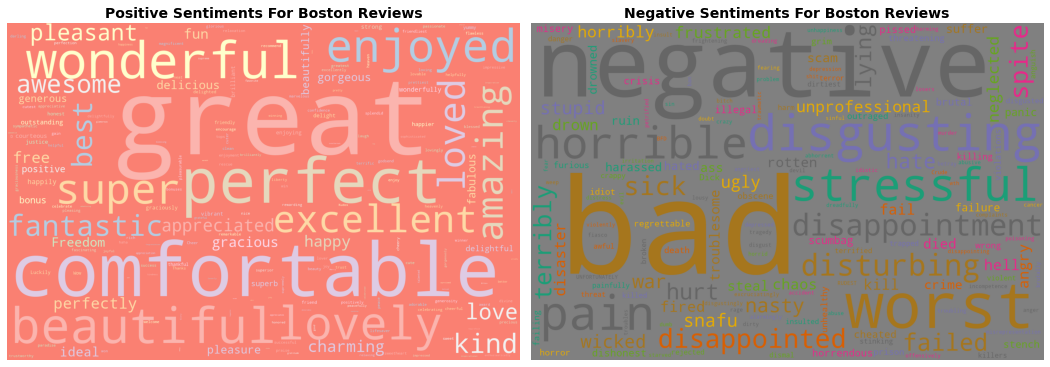

In [118]:
swc = SentimentsWordCloud(reviews,'comments',groupby='city', english=True)
vizGen = swc.wordCloudViz()
next(vizGen)

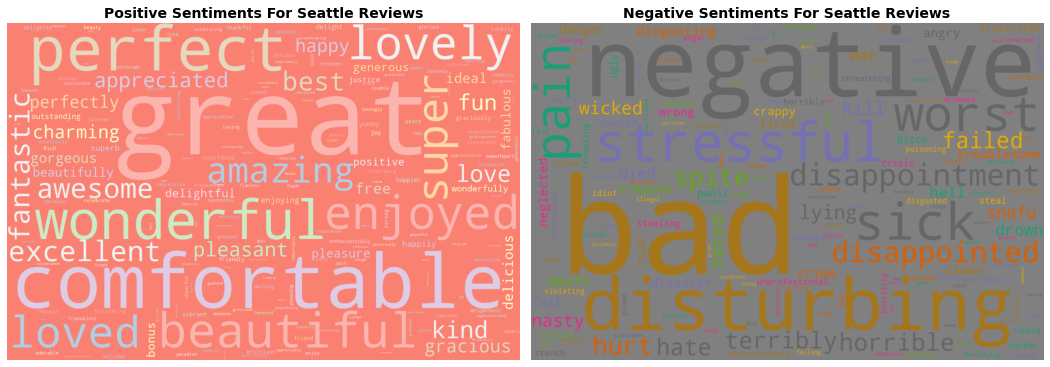

In [119]:
next(vizGen)

In [120]:
highlightKeywords(eng_comments,'comments',' dead ')

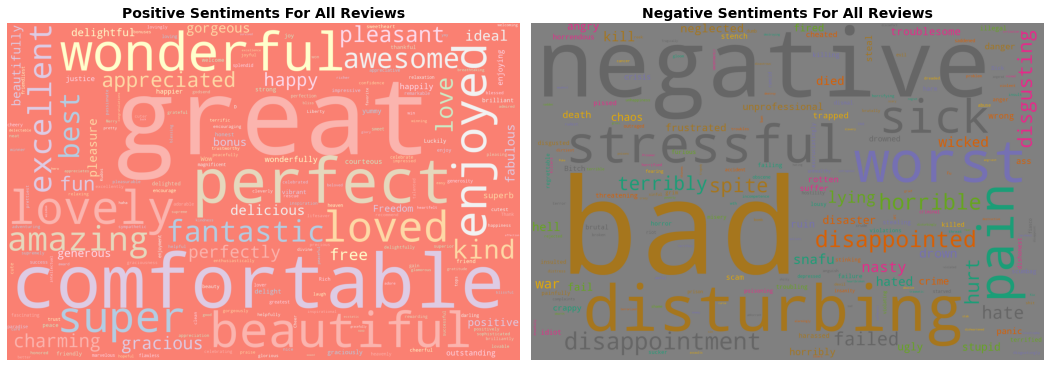

In [121]:
swc = SentimentsWordCloud(reviews,'comments',english=True,stopwords=['die','dead','rob','killer'])
vizGen = swc.wordCloudViz()
next(vizGen)

#### Word Clouds Proportional To Sentiments Expressed

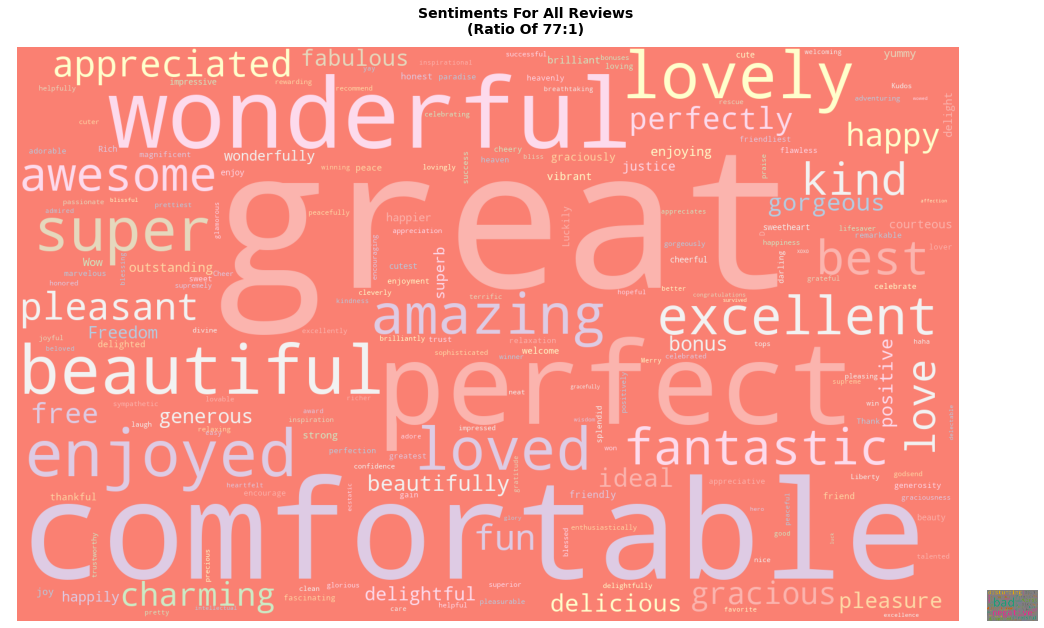

In [122]:
swc = SentimentsWordCloud(reviews,'comments',english=True,stopwords=['die','dead','rob','killer'],proportional=True)
vizGen = swc.wordCloudViz()
next(vizGen)

#### Time Taken
        Grouped by city, english language only: Time Taken: 303.38720989227295 seconds
                            loaded from pickle: Time Taken: 15.748566150665283 seconds

In [123]:
# display(myHTML(f"For all reviews: The number of negative words {len(sentiments_all['Negative'])}; The number of positive words {len(sentiments_all['Positive'])}"))

In [124]:
def sentimentCount(allComments, cityComments):
    # number of positive/negative words
    len_all_pos = len(allComments['Positive'])
    len_all_neg = len(allComments['Negative'])
    len_bos_pos = len(cityComments["Boston"]['Positive'])
    len_bos_neg = len(cityComments["Boston"]['Negative'])
    len_sea_pos = len(cityComments["Seattle"]['Positive'])
    len_sea_neg = len(cityComments["Seattle"]['Negative'])
    top_all_neg = pd.Series(allComments['Negative']).value_counts().index[:10]
    top_bos_neg = pd.Series(cityComments["Boston"]['Negative']).value_counts().index[:10]
    top_sea_neg = pd.Series(cityComments["Seattle"]['Negative']).value_counts().index[:10]
    display(myHTML(f'''For all reviews: The number of negative words {len_all_neg}; The number of positive words {len_all_pos};
    For a proportion of positive of {round(len_all_pos/(len_all_pos+len_all_neg),2)}.<br>The top 10 negative words are: {", ".join(top_all_neg)}'''.title()))
    display(myHTML(f'''For boston reviews: The number of negative words {len_bos_neg}; The number of positive words {len_bos_pos};
    For a proportion of positive of {round(len_bos_pos/(len_bos_pos+len_bos_neg),2)}.<br>The top 10 negative words are: {", ".join(top_bos_neg)}'''.title()))
    display(myHTML(f'''For seattle reviews: The number of negative words {len_sea_neg}; The number of positive words {len_sea_pos};
    For a proportion of positive of {round(len_sea_pos/(len_sea_pos+len_sea_neg),2)}.<br>The top 10 negative words are: {", ".join(top_sea_neg)}'''.title()))

In [125]:
# sentimentCount(sentiments_all, city_sentiment)

In [126]:
# sentimentCount(sentiments_all_eng, city_sentiment_eng)

In [127]:
display(myHTML("<h2>Decision About Merging</h2)"))

None

#### Do the dataframes include the same listings?

In [131]:
[x for x in recent_calendar.listing_id.values if x not in listings.id.values]

[]

In [132]:
[x for x in listings.id.values if x not in recent_calendar.listing_id.values]

[]

In [133]:
[x for x in recent_reviews.listing_id.values if x not in listings.id.values]

[]

In [134]:
missing_reviews = [x for x in listings.id.values if x not in recent_reviews.listing_id.values]

display(HTML(f'''There are {len(missing_reviews)} listings that are not included in the reviews dataframe. That is {round(100*len(missing_reviews)/len(listings),2)}%.
This matches the missing reviews from the listings dataframe (i.e. where Number of Listings is zero): {len(listings.loc[listings.number_of_reviews == 0])}'''))

All listings, in the listings data, are in the calendar data file. But close to 19% are missing from the reviews data.

In [135]:
[x for x in listings.columns if 'review' in x.lower()]

['number_of_reviews',
 'first_review',
 'last_review',
 'review_scores_rating',
 'review_scores_accuracy',
 'review_scores_cleanliness',
 'review_scores_checkin',
 'review_scores_communication',
 'review_scores_location',
 'review_scores_value',
 'reviews_per_month',
 'Review Scores Rating Percentiles']

In [136]:
len(listings.loc[listings.number_of_reviews == 0])

1383

In [137]:
def groupbyPerc(df,var1,var2):
    '''
    groupbyPerc: group dataframe df by var1 and var2
                 unstack var2
                 get percentages for each category in var2 (for each in var1)
                 generate horizontal bar plot
    '''
    (df.groupby([var1,var2])
       .size()
       .unstack(var2)
       .apply(lambda x: x*100/x.sum(), axis=1)
       .plot.barh(width=0.9,
                 figsize=[14.70, 8.27]))
    plt.title(f"Percentage {var2} by {var1}".title(), fontsize=14, weight="bold")
    plt.ylabel(f"{var1}".title())
    plt.xlabel("Percentage".title())
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5),
           title=f"{var2}".title(), title_fontsize = 12);
    
def groupbyAvg(df,var1,var2,label='',legend=False):
    '''
    groupbyPerc: group dataframe df by var1
                 get average for each category in var2 (for each in var1)
                 generate horizontal bar plot
    '''
    (df.groupby([var1])[var2]
       .mean()
       .plot.barh(width=0.9,
                 figsize=[14.70, 8.27]))
    plt.title(f"Average {var2.replace('_',' ')} by {var1.replace('_',' ')}".title(), fontsize=14, weight="bold")
    plt.ylabel(f"{var1}".title())
    plt.xlabel(f"Average {var2.replace('_',' ')} {label}".title())
    if legend:
        plt.legend(loc='center left', bbox_to_anchor=(1, 0.5),
               title=f"{var2}".title(), title_fontsize = 12);

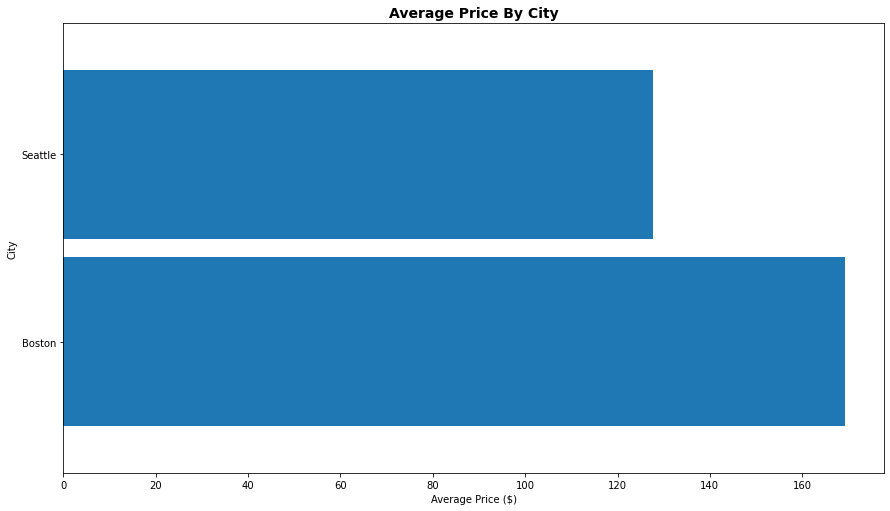

In [138]:
groupbyAvg(listings,"city","price",label="($)")

In [139]:
listings.price.myDescribe()

count   7403.00
mean     147.80
std      102.89
min        0.00
0%         0.00
10%       55.00
20%       70.00
30%       85.00
40%      100.00
50%      120.00
60%      145.00
70%      170.00
80%      200.00
90%      275.00
100%     999.00
max      999.00
Name: price, dtype: float64

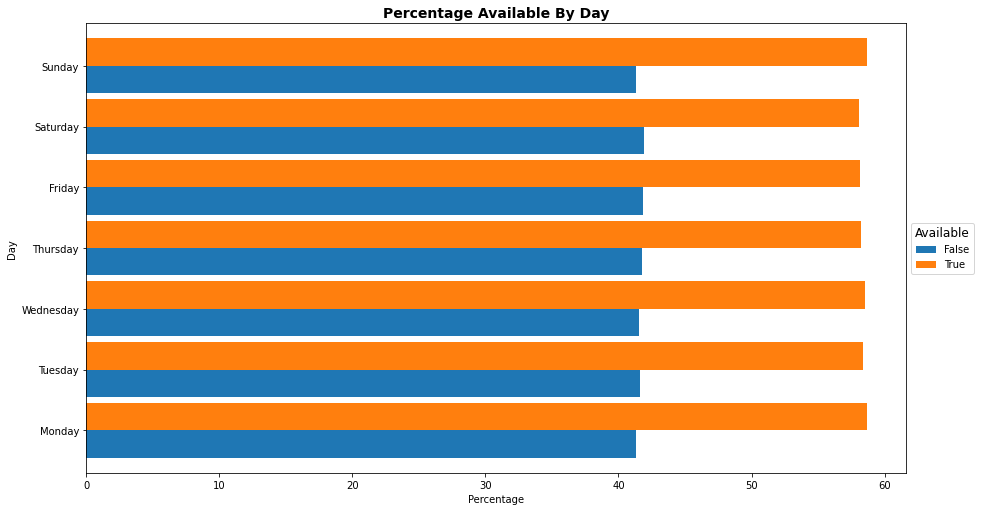

In [140]:
groupbyPerc(calendar,"day","available")

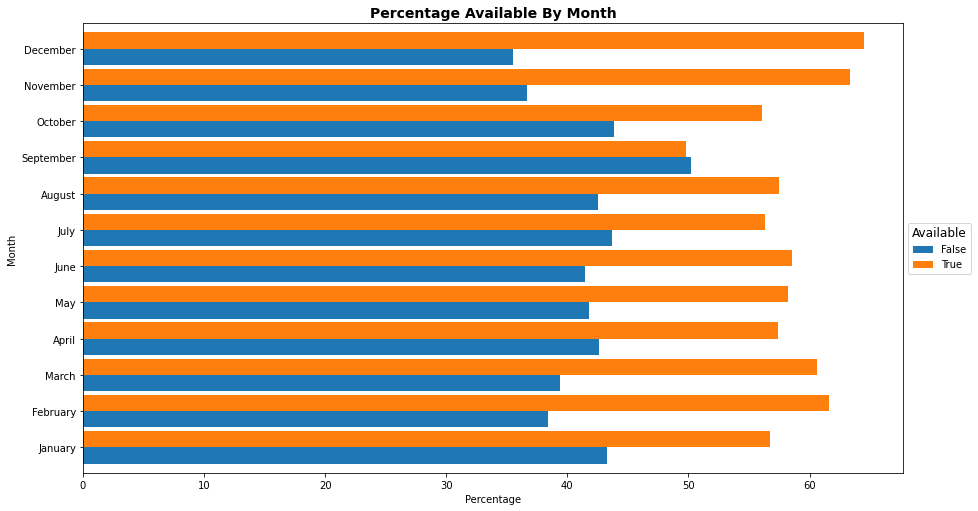

In [141]:
groupbyPerc(calendar,"month","available")

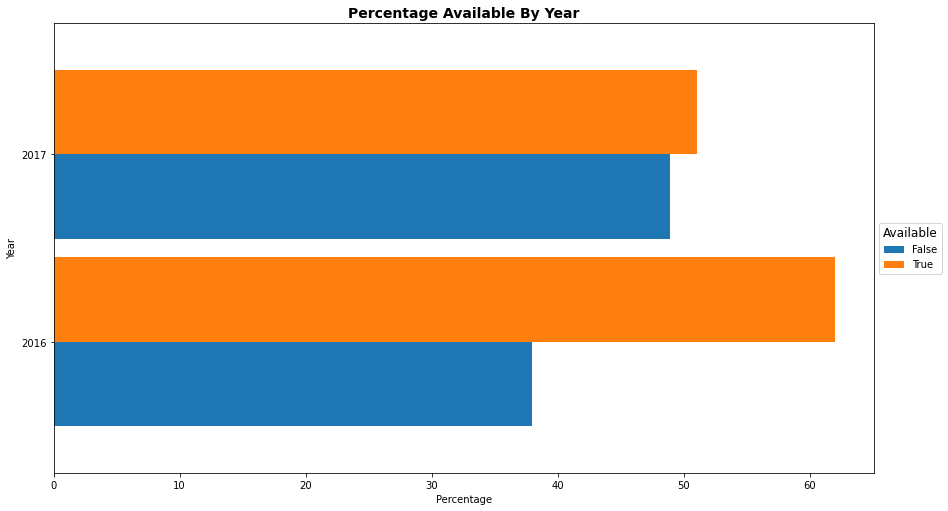

In [142]:
groupbyPerc(calendar,"year","available")

              city_merge
              Boston    127.976
              Seattle   173.926
              Name: price, dtype: float64

In [143]:
calendar.describe().T

count       mean        std     min        25%        50%  \
listing_id 2702460.00 6950804.94 4052439.85 3335.00 3865312.75 7035369.00   
price      1577579.00     162.60     143.70   10.00      79.00     120.00   
year       2702460.00    2016.33       0.47 2016.00    2016.00    2016.00   

                  75%         max  
listing_id 9504211.25 14933461.00  
price          200.00     7163.00  
year          2017.00     2017.00

In [144]:
listings.describe().T

count              mean          std  \
id                             7403.00        6950001.48   4052396.78   
scrape_id                      7403.00 20160492479532.68 400929617.51   
host_id                        7403.00       20210534.87  19623093.35   
host_listings_count            7401.00             32.22       123.59   
host_total_listings_count      7401.00             32.22       123.59   
latitude                       7403.00             45.07         2.64   
longitude                      7403.00            -97.52        25.61   
accommodates                   7403.00              3.20         1.89   
bathrooms                      7373.00              1.24         0.55   
bedrooms                       7387.00              1.28         0.82   
beds                           7393.00              1.67         1.08   
square_feet                     153.00            856.03       647.19   
price                          7403.00            147.80       102.89   
guests_included                7403.00              1.56         1.20   
minimum_nights                 7403.00              2.76        13.24   
maximum_nights                 7403.00          14313.37   1162232.13   
availability_30                7403.00             12.85        12.07   
availability_60                7403.00             29.56        23.84   
availability_90                7403.00             48.63        35.01   
availability_365               7403.00            213.09       138.34   
number_of_reviews              7403.00             20.68        36.73   
review_scores_rating           5943.00             93.32         8.21   
review_scores_accuracy         5922.00              9.54         0.82   
review_scores_cleanliness      5932.00              9.42         1.00   
review_scores_checkin          5925.00              9.72         0.68   
review_scores_communication    5934.00              9.73         0.66   
review_scores_location         5926.00              9.52         0.78   
review_scores_value            5926.00              9.32         0.89   
license                           0.00               NaN          NaN   
calculated_host_listings_count 7403.00              7.69        21.47   
reviews_per_month              6020.00              2.03         1.97   
year                           7403.00           2016.00         0.00   

                                             min               25%  \
id                                       3335.00        3864099.50   
scrape_id                      20160104002432.00 20160104002432.00   
host_id                                  4193.00        4343163.50   
host_listings_count                         0.00              1.00   
host_total_listings_count                   0.00              1.00   
latitude                                   42.24             42.35   
longitude                                -122.42           -122.33   
accommodates                                1.00              2.00   
bathrooms                                   0.00              1.00   
bedrooms                                    0.00              1.00   
beds                                        0.00              1.00   
square_feet                                 0.00            420.00   
price                                       0.00             79.00   
guests_included                             0.00              1.00   
minimum_nights                              1.00              1.00   
maximum_nights                              1.00             95.50   
availability_30                             0.00              0.00   
availability_60                             0.00              1.00   
availability_90                             0.00              7.00   
availability_365                            0.00             77.00   
number_of_reviews                           0.00              1.00   
review_scores_rating                       20.00             91.00   
review_scores

In [145]:
reviews.describe().T

count        mean         std     min         25%         50%  \
listing_id  153124.00  3787517.47  3248161.22 3353.00  1071843.00  3139972.00   
id          153124.00 40342403.39 24778966.56 1021.00 20620259.75 38463998.00   
reviewer_id 153124.00 21922545.05 18816034.68   15.00  6342335.75 17552614.00   
year        153124.00     2014.72        1.06 2009.00     2014.00     2015.00   

                    75%         max  
listing_id   5958674.00 14843783.00  
id          53978187.50 99990454.00  
reviewer_id 32977175.50 93350341.00  
year            2015.00     2016.00

In [146]:
listings.head(1).T

0
id                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                12147973
listing_url                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          https://www.airbnb.com/rooms/12147973
scrape_id                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   20160906204935
last_scraped                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 

In [147]:
# # create a float from price data
# if isinstance(listings["price"][0],str):
#     listings["price"]=listings.price.str.extract(r'(\d+\.\d+)').astype(float)

# nlistings = listings.join(listings.groupby("zipcode").id.transform('size'),rsuffix="_d")
# nlistings = nlistings.rename({"id_d":"zip_count"},axis=1)
# zipOne = nlistings.groupby("zipcode").first().reset_index()
# zipOne['zip_count'] = zipOne.zip_count.astype(int)

## Let's Remove Non-English Reviews

In [148]:
!jupyter nbconvert p1_blog_airBnB.ipynb --to html

[NbConvertApp] Converting notebook p1_blog_airBnB.ipynb to html
[NbConvertApp] Writing 10172346 bytes to p1_blog_airBnB.html


In [149]:
!jupyter nbconvert p1_blog_airBnB.ipynb --TemplateExporter.exclude_input=True --TemplateExporter.exclude_input_prompt=True --to markdown

[NbConvertApp] Converting notebook p1_blog_airBnB.ipynb to markdown
[NbConvertApp] Support files will be in p1_blog_airBnB_files/
[NbConvertApp] Making directory p1_blog_airBnB_files
[NbConvertApp] Making directory p1_blog_airBnB_files
[NbConvertApp] Making directory p1_blog_airBnB_files
[NbConvertApp] Making directory p1_blog_airBnB_files
[NbConvertApp] Making directory p1_blog_airBnB_files
[NbConvertApp] Making directory p1_blog_airBnB_files
[NbConvertApp] Making directory p1_blog_airBnB_files
[NbConvertApp] Making directory p1_blog_airBnB_files
[NbConvertApp] Making directory p1_blog_airBnB_files
[NbConvertApp] Making directory p1_blog_airBnB_files
[NbConvertApp] Making directory p1_blog_airBnB_files
[NbConvertApp] Making directory p1_blog_airBnB_files
[NbConvertApp] Making directory p1_blog_airBnB_files
[NbConvertApp] Making directory p1_blog_airBnB_files
[NbConvertApp] Making directory p1_blog_airBnB_files
[NbConvertApp] Making directory p1_blog_airBnB_files
[NbConvertApp] Writing

In [150]:
!jupyter nbconvert p1_blog_airBnB.ipynb --to html  --no-input --no-prompt 

[NbConvertApp] Converting notebook p1_blog_airBnB.ipynb to html
[NbConvertApp] Writing 10000359 bytes to p1_blog_airBnB.html


In [151]:
!jupyter nbconvert --to html --TemplateExporter.exclude_input=True p1_blog_airBnB.ipynb

[NbConvertApp] Converting notebook p1_blog_airBnB.ipynb to html
[NbConvertApp] Writing 10005527 bytes to p1_blog_airBnB.html


In [1]:
!jupyter nbconvert --to markdown --TemplateExporter.exclude_input=True p1_blog_airBnB.ipynb

[NbConvertApp] Converting notebook p1_blog_airBnB.ipynb to markdown
[NbConvertApp] Support files will be in p1_blog_airBnB_files/
[NbConvertApp] Making directory p1_blog_airBnB_files
[NbConvertApp] Making directory p1_blog_airBnB_files
[NbConvertApp] Making directory p1_blog_airBnB_files
[NbConvertApp] Making directory p1_blog_airBnB_files
[NbConvertApp] Making directory p1_blog_airBnB_files
[NbConvertApp] Making directory p1_blog_airBnB_files
[NbConvertApp] Making directory p1_blog_airBnB_files
[NbConvertApp] Making directory p1_blog_airBnB_files
[NbConvertApp] Making directory p1_blog_airBnB_files
[NbConvertApp] Making directory p1_blog_airBnB_files
[NbConvertApp] Making directory p1_blog_airBnB_files
[NbConvertApp] Making directory p1_blog_airBnB_files
[NbConvertApp] Making directory p1_blog_airBnB_files
[NbConvertApp] Making directory p1_blog_airBnB_files
[NbConvertApp] Making directory p1_blog_airBnB_files
[NbConvertApp] Making directory p1_blog_airBnB_files
[NbConvertApp] Writing

In [158]:
1/np.exp (-0.0150)

1.015113064615719

In [159]:
np.exp (-0.0150)

0.9851119396030626

In [160]:
np.exp (-0.0150)/ (1 + np.exp (-0.0150))

0.496250070310918

In [162]:
(1/np.exp (-0.0150))/(1+(1/np.exp (-0.0150)))

0.5037499296890819